In [2]:
import sys
from pathlib import Path

AVES_ROOT = Path("../../..")

EOD_PATH = AVES_ROOT / "data" / "external" / "EOD_STGO"
EOD_PATH

PosixPath('../../../data/external/EOD_STGO')

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import geopandas as gpd

from aves.data import eod, census
from aves.features.utils import normalize_rows

# esto configura la calidad de la imagen. dependerá de tu resolución. el valor por omisión es 80
mpl.rcParams["figure.dpi"] = 192
# esto depende de las fuentes que tengas instaladas en el sistema.
mpl.rcParams["font.family"] = "Fira Sans Extra Condensed"

In [4]:
people = eod.read_people(EOD_PATH).drop('NoUsaTransantiago', axis=1)#.merge(eod.read_transantiago_usage(EOD_PATH))
people

,Hogar,Persona,AnoNac,Sexo,Relacion,Viajes,LicenciaConducir,PaseEscolar,AdultoMayor,Estudios,...,TramoIngreso,IngresoFinal,TramoIngresoFinal,IngresoImputado,Factor_LaboralNormal,Factor_SabadoNormal,Factor_DomingoNormal,Factor_LaboralEstival,Factor_FindesemanaEstival,FactorPersona
0,100010,10001001,1958,Hombre,Jefe(a) de Hogar,2,3,2,2,4.0,...,Entre 200.001 y 400.000 pesos,240000,2,0,NaN,NaN,1668.2600,NaN,NaN,82.58553
1,100010,10001002,1956,Mujer,Cónyuge o pareja,5,1,2,2,5.0,...,NaN,0,0,0,NaN,NaN,852.1137,NaN,NaN,99.53422
2,100010,10001003,1982,Mujer,Hijo o Hija,0,1,2,2,7.0,...,Entre 200.001 y 400.000 pesos,210845,2,2,NaN,NaN,1609.1630,NaN,NaN,151.59367
3,100020,10002001,1954,Hombre,Jefe(a) de Hogar,4,3,2,2,4.0,...,Menos de 200.000 pesos,133000,1,0,169.50230,NaN,NaN,NaN,NaN,45.21325
4,100020,10002002,1961,Mujer,Cónyuge o pareja,2,1,2,2,4.0,...,Menos de 200.000 pesos,193000,1,0,43.26765,NaN,NaN,NaN,NaN,25.62248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60049,706791,70679101,1956,Mujer,Cónyuge o pareja,2,1,2,2,4.0,...,NaN,0,0,0,NaN,NaN,320.9519,NaN,NaN,17.87670
60050,706791,70679102,1955,Hombre,Jefe(a) de Hogar,0,1,2,2,5.0,...,Entre 200.001 y 400.000 pesos,396715,2,2,NaN,NaN,320.9519,NaN,NaN,21.07324
60051,743813,74381301,1943,Hombre,Jefe(a) de Hogar,2,1,2,2,5.0,...,Menos de 200.000 pesos,140369,1,2,NaN,NaN,281.4610,NaN,NaN,15.34897
60052,743813,74381302,1943,Mujer,Cónyuge o pareja,2,1,2,2,4.0,...,Menos de 200.000 pesos,177636,1,2,NaN,NaN,288.1693,NaN,NaN,17.30931


In [5]:
homes = eod.read_homes(EOD_PATH)

In [6]:
trips = eod.read_trips(EOD_PATH).merge(people).merge(homes)

# descartamos sectores que no sean relevantes en los orígenes y destinos de los viajes
trips = trips[
    (trips["SectorOrigen"] != "Exterior a RM")
    & (trips["SectorDestino"] != "Exterior a RM")
    & (trips["SectorOrigen"] != "Extensión Sur-Poniente")
    & (trips["SectorDestino"] != "Extensión Sur-Poniente")
    & pd.notnull(trips["SectorOrigen"])
    & pd.notnull(trips["SectorDestino"])
]

trips["PesoLaboral"] = trips["FactorLaboralNormal"] * trips["Factor_LaboralNormal"]

trips = trips[pd.notnull(trips["PesoLaboral"])]

print(len(trips))

58511


In [7]:
people['Persona']#tp_usage.columns

0        10001001
1        10001002
2        10001003
3        10002001
4        10002002
           ...   
60049    70679101
60050    70679102
60051    74381301
60052    74381302
60053    74382301
Name: Persona, Length: 60054, dtype: int64

In [8]:
tp_usage = (
    eod.read_transantiago_usage()
    .pipe(
        lambda x: x[
            x["NoUsaTransantiago"]
            != "Utiliza transantiago, pero no lo utilizó el Día de Registro de Viaje por otras razones"
        ]
    )
    .groupby("Persona")["NoUsaTransantiago"]
    .value_counts()
    .unstack(fill_value=0)
    .mul(people.set_index("Persona")["FactorPersona"], axis="index")
    .dropna()
)

tp_usage.sum(axis=0).astype(int)

NoUsaTransantiago
Baja frecuencia de los buses                                                                596305
Dificultad para calcular los tiempos de viaje (no sabe cuánto demorará en pasar el bus)     203584
Hay que realizar muchas combinaciones (entre buses y/o Metro)                               250147
Incómodo (los buses y/o metro van muy llenos)                                               536372
Ninguna estación de Metro le queda cerca del origen o destino de sus viajes habituales       77204
No lo utiliza por otra razón (especifique)                                                 1098652
Poco seguro (asaltos, hurtos, etc)                                                          188989
dtype: int64

In [9]:
adults = people[people["AnoNac"] <= 1994].set_index("Persona")
len(adults), adults['FactorPersona'].sum()

(46063, 4977099.375529999)

In [10]:
from aves.features.utils import normalize_rows

sex_table = (
    tp_usage.join(adults["Sexo"])
    .groupby("Sexo")
    .sum()
    .T.pipe(normalize_rows)
    .sort_values("Hombre")
)
sex_table

Sexo,Hombre,Mujer
"Poco seguro (asaltos, hurtos, etc)",0.392924,0.607076
Baja frecuencia de los buses,0.491985,0.508015
Ninguna estación de Metro le queda cerca del origen o destino de sus viajes habituales,0.506332,0.493668
No lo utiliza por otra razón (especifique),0.518130,0.481870
Incómodo (los buses y/o metro van muy llenos),0.521252,0.478748
Hay que realizar muchas combinaciones (entre buses y/o Metro),0.526267,0.473733
Dificultad para calcular los tiempos de viaje (no sabe cuánto demorará en pasar el bus),0.545941,0.454059


/tmp/ipykernel_24404/2786288488.py:10: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


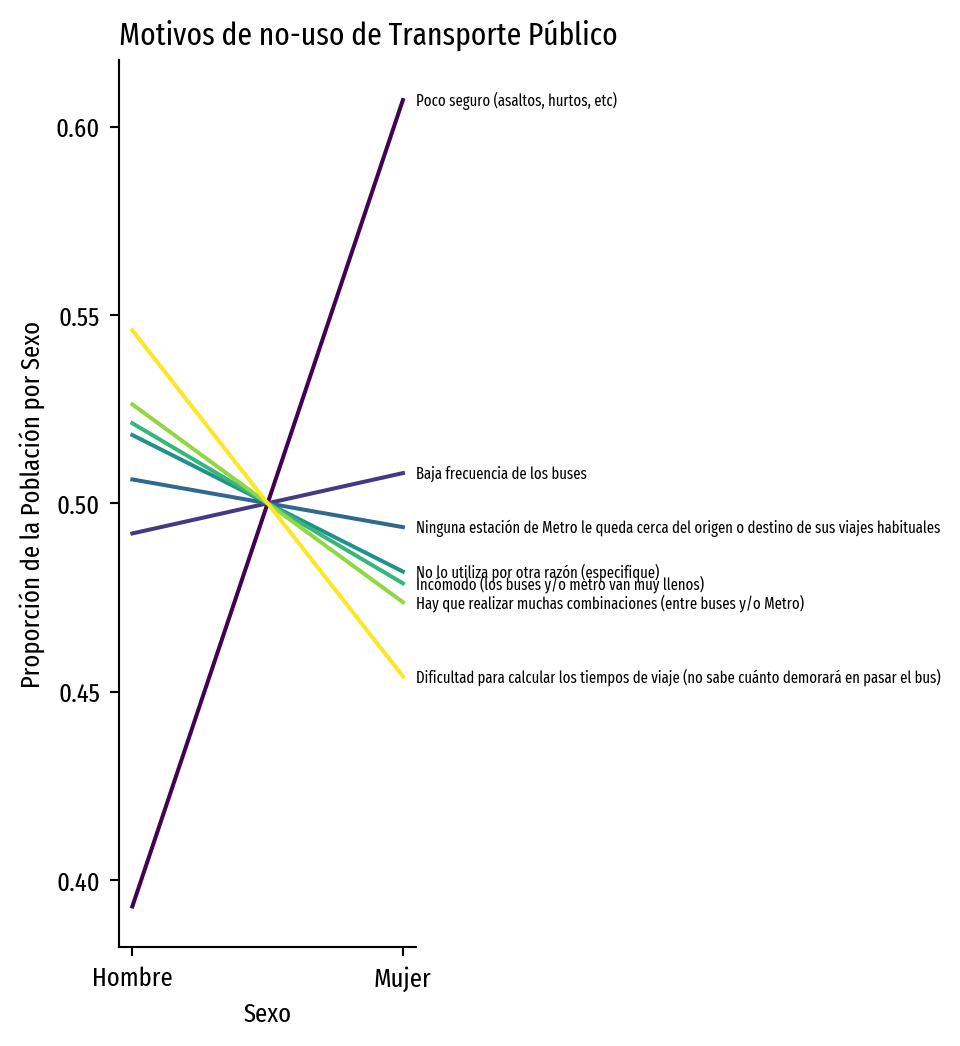

In [11]:
fig, ax = plt.subplots(figsize=(2.5, 6))
sex_table.T.plot(figsize=(2, 6), legend=None, ax=ax, cmap='viridis')
ax.get_xticks()
ax.set_xticks([0, 1], labels=sex_table.columns)
ax.set_ylabel('Proporción de la Población por Sexo')
for idx, row in sex_table.iterrows():
    ax.annotate(idx, (1.05, row['Mujer']), ha='left', va='center', fontsize=6)
sns.despine(ax=ax)
ax.set_title('Motivos de no-uso de Transporte Público', loc='left')
fig.tight_layout()

Text(16.5, -10, 'Más viajes de Mujeres $\\downarrow$')

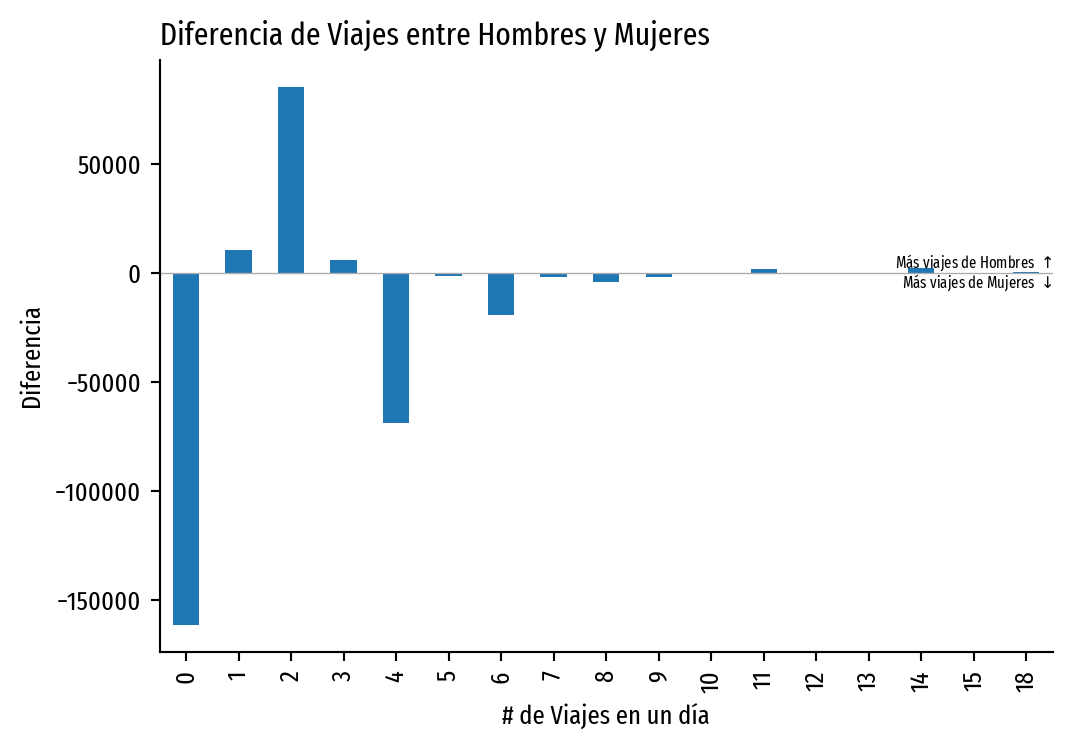

In [12]:
diff_sex_trips = adults.groupby(['Sexo', 'Viajes'])['FactorPersona'].sum().unstack(fill_value=0).T.assign(diff=lambda x: x['Hombre'] - x['Mujer'])

fig, ax = plt.subplots(figsize=(6, 4))

diff_sex_trips['diff'].plot(kind='bar', ax=ax)
sns.despine(ax=ax)
ax.set_ylabel('Diferencia')
ax.set_xlabel('# de Viajes en un día')
ax.set_title('Diferencia de Viajes entre Hombres y Mujeres', loc='left')

ax.axhline(y=0, linewidth=0.5, color='#abacab')
ax.annotate('Más viajes de Hombres $\\uparrow$', (16.5, 10), ha='right', va='bottom', fontsize=6)
ax.annotate('Más viajes de Mujeres $\\downarrow$', (16.5, -10), ha='right', va='top', fontsize=6)

In [13]:
zones = gpd.read_file(
    AVES_ROOT / "data" / "processed" / "scl_zonas_urbanas.json"
).drop_duplicates(subset="ID")
zones.head()

,ID,AREA,Zona,Com,Comuna,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,URBANO,TIPO,NOM_CATEG,SHAPE_Leng,SHAPE_Area,area_m2,geometry
0,103,837.7500,103.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,4.575649e+05,"POLYGON ((-70.65492 -33.55500, -70.65517 -33.5..."
1,104,998.8125,104.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.725462e+05,"POLYGON ((-70.67599 -33.55542, -70.67452 -33.5..."
2,106,286.2500,106.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,2.693838e+06,"POLYGON ((-70.67891 -33.55911, -70.68019 -33.5..."
3,115,857.4375,115.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.534193e+05,"POLYGON ((-70.67625 -33.55513, -70.67653 -33.5..."
4,116,853.9375,116.0,13105,El Bosque,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13105,EL BOSQUE,EL BOSQUE,CAPITAL COMUNAL,CIUDAD,0.152123,0.001391,7.184305e+05,"POLYGON ((-70.66564 -33.55260, -70.66309 -33.5..."


In [14]:
analysis_trips = trips[
    (trips["Proposito"] != "volver a casa") & (trips["AnoNac"] <= 1994)
]
len(analysis_trips)

26032

In [15]:
analysis_trips["tp_user"] = (~analysis_trips["Persona"].isin(tp_usage.index)).astype(
    int
)
analysis_trips["tp_user"].describe()

/tmp/ipykernel_24404/3777641638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_trips["tp_user"] = (~analysis_trips["Persona"].isin(tp_usage.index)).astype(


count    26032.000000
mean         0.698525
std          0.458907
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: tp_user, dtype: float64

In [17]:
from aves.features.utils import tfidf

zone_associations = (
    analysis_trips.groupby(["ZonaDestino", "tp_user", "Sexo"])["PesoLaboral"]
    .sum()
    .unstack()
    .unstack()
    .fillna(0)
    .pipe(tfidf)
)

zone_associations

Sexo           Hombre               Mujer          
tp_user             0         1         0         1
ZonaDestino                                        
1            0.090588  0.196988  0.178619  0.533805
2            0.186589  0.151091  0.141205  0.521115
3            0.809431  0.048320  0.029829  0.112420
4            0.102258  0.343323  0.024210  0.530210
5            0.178606  0.132582  0.072196  0.616615
...               ...       ...       ...       ...
798          0.807813  0.000000  0.000000  0.192187
799          0.618193  0.024972  0.148414  0.208422
800          1.000000  0.000000  0.000000  0.000000
801          1.000000  0.000000  0.000000  0.000000
803          0.483957  0.175462  0.236469  0.104112

[779 rows x 4 columns]

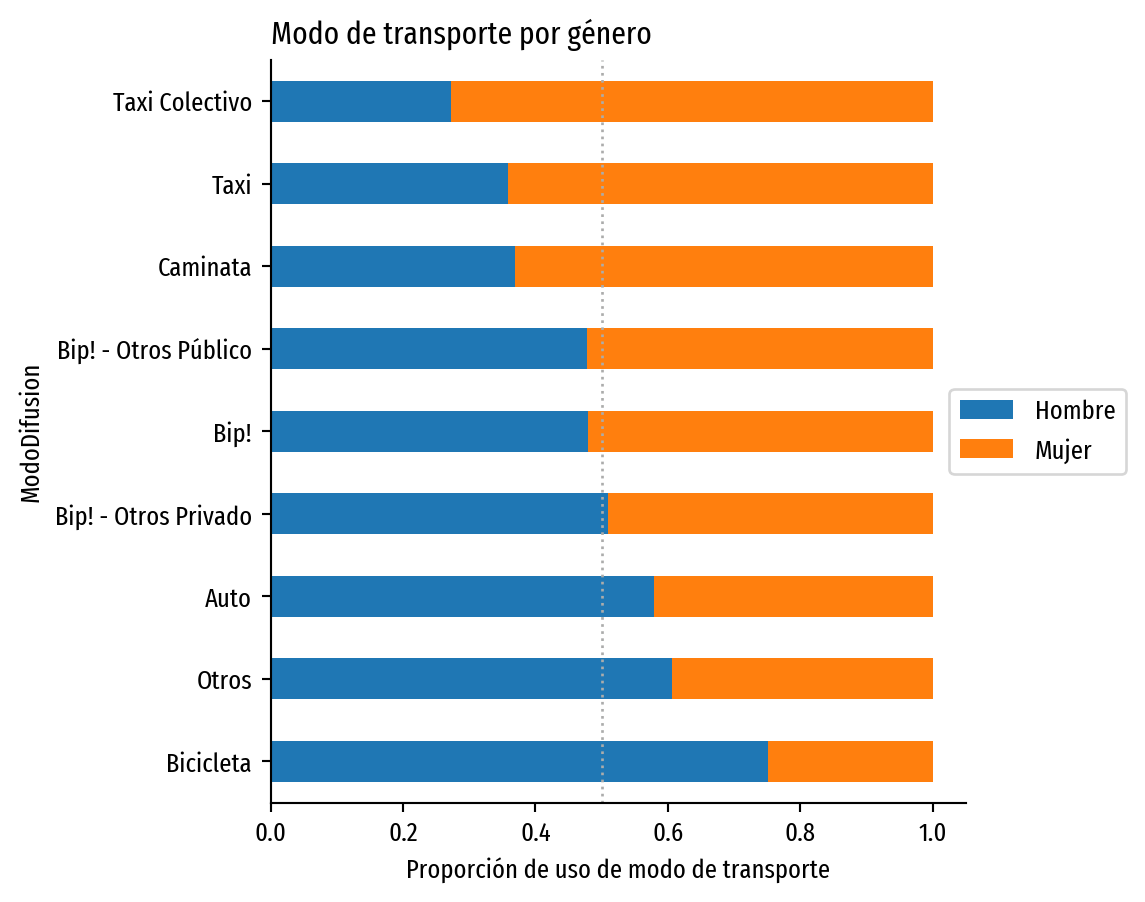

In [39]:
fig, ax = plt.subplots()


(
    analysis_trips.groupby(["ModoDifusion", "Sexo"])["PesoLaboral"]
    .sum()
    .unstack()
    .pipe(normalize_rows)
    .sort_values("Mujer")
    .plot(kind="barh", stacked=True, ax=ax)
)

sns.despine(ax=ax)
ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.0, 0.25, 1.0))
ax.set_title("Modo de transporte por género", loc="left")
ax.set_xlabel("Proporción de uso de modo de transporte")
ax.axvline(x=0.5, linestyle="dotted", color="#abacab", linewidth=1)
fig.tight_layout()

In [19]:
analysis_trips['dist_bin'] = pd.qcut(analysis_trips['DistManhattan'], 20)
analysis_trips['dist_bin'].value_counts()

/tmp/ipykernel_24404/727457703.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_trips['dist_bin'] = pd.qcut(analysis_trips['DistManhattan'], 20)


dist_bin
(-0.001, 442.0]        1306
(802.1, 1179.0]        1305
(14889.2, 17311.0]     1304
(8086.6, 9446.0]       1304
(4120.0, 4914.0]       1302
(20328.8, 24555.95]    1302
(10987.2, 12740.5]     1302
(5887.0, 6983.0]       1302
(3347.0, 4120.0]       1302
(2721.3, 3347.0]       1302
(24555.95, 65047.0]    1302
(4914.0, 5887.0]       1301
(2159.0, 2721.3]       1301
(12740.5, 14889.2]     1301
(1639.0, 2159.0]       1301
(6983.0, 8086.6]       1300
(9446.0, 10987.2]      1299
(17311.0, 20328.8]     1299
(1179.0, 1639.0]       1299
(442.0, 802.1]         1298
Name: count, dtype: int64

/tmp/ipykernel_24404/985832948.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_trips.groupby(["Sexo", "dist_bin"])["PesoLaboral"].sum().unstack().T.plot(


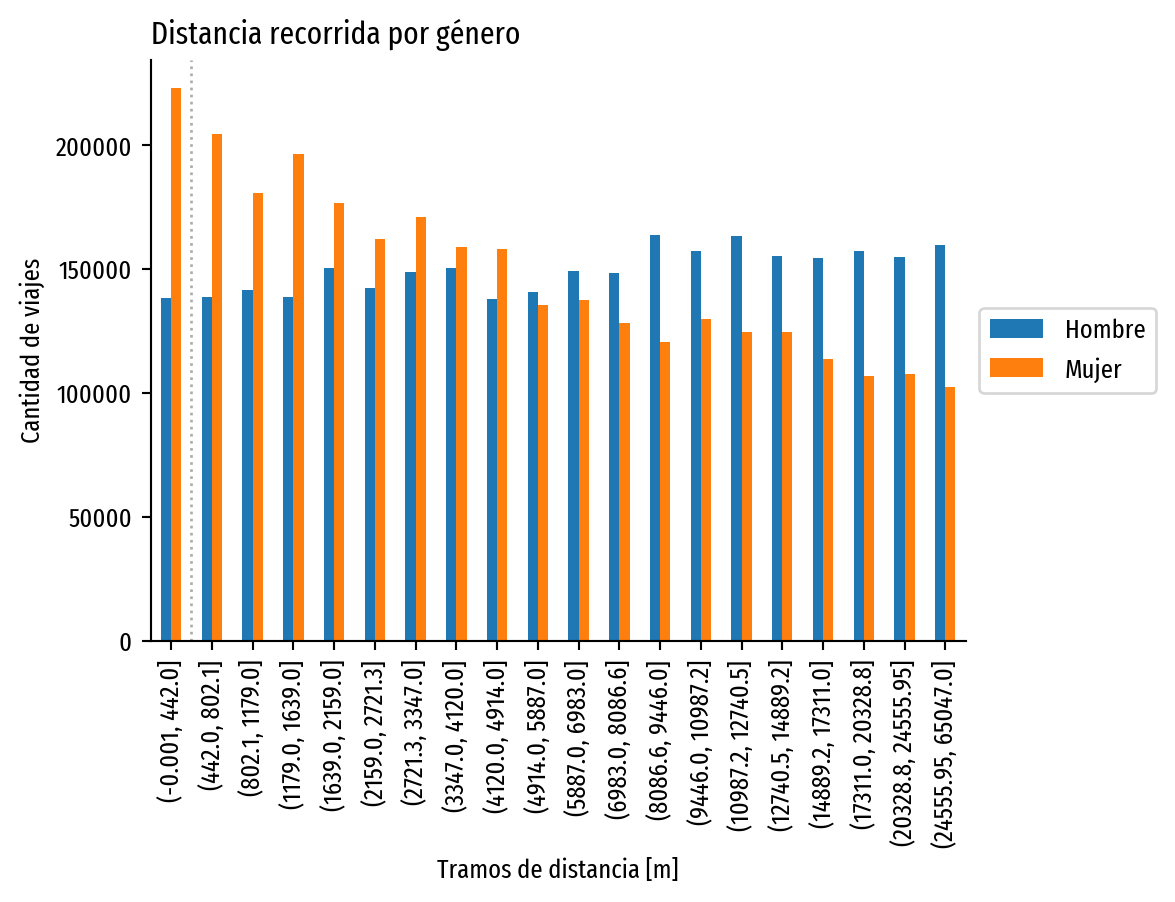

In [41]:
fig, ax = plt.subplots()

analysis_trips.groupby(["Sexo", "dist_bin"])["PesoLaboral"].sum().unstack().T.plot(
    kind="bar", ax=ax
)

sns.despine(ax=ax)
ax.legend(loc="center right", bbox_to_anchor=(1.0, 0.0, 0.25, 1.0))
ax.set_title("Distancia recorrida por género", loc="left")
ax.set_xlabel("Tramos de distancia [m]")
ax.set_ylabel('Cantidad de viajes')
ax.axvline(x=0.5, linestyle="dotted", color="#abacab", linewidth=1)
fig.tight_layout()

/tmp/ipykernel_24404/3631175560.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  analysis_trips.groupby(["Sexo", "Proposito", "dist_bin"])["PesoLaboral"]


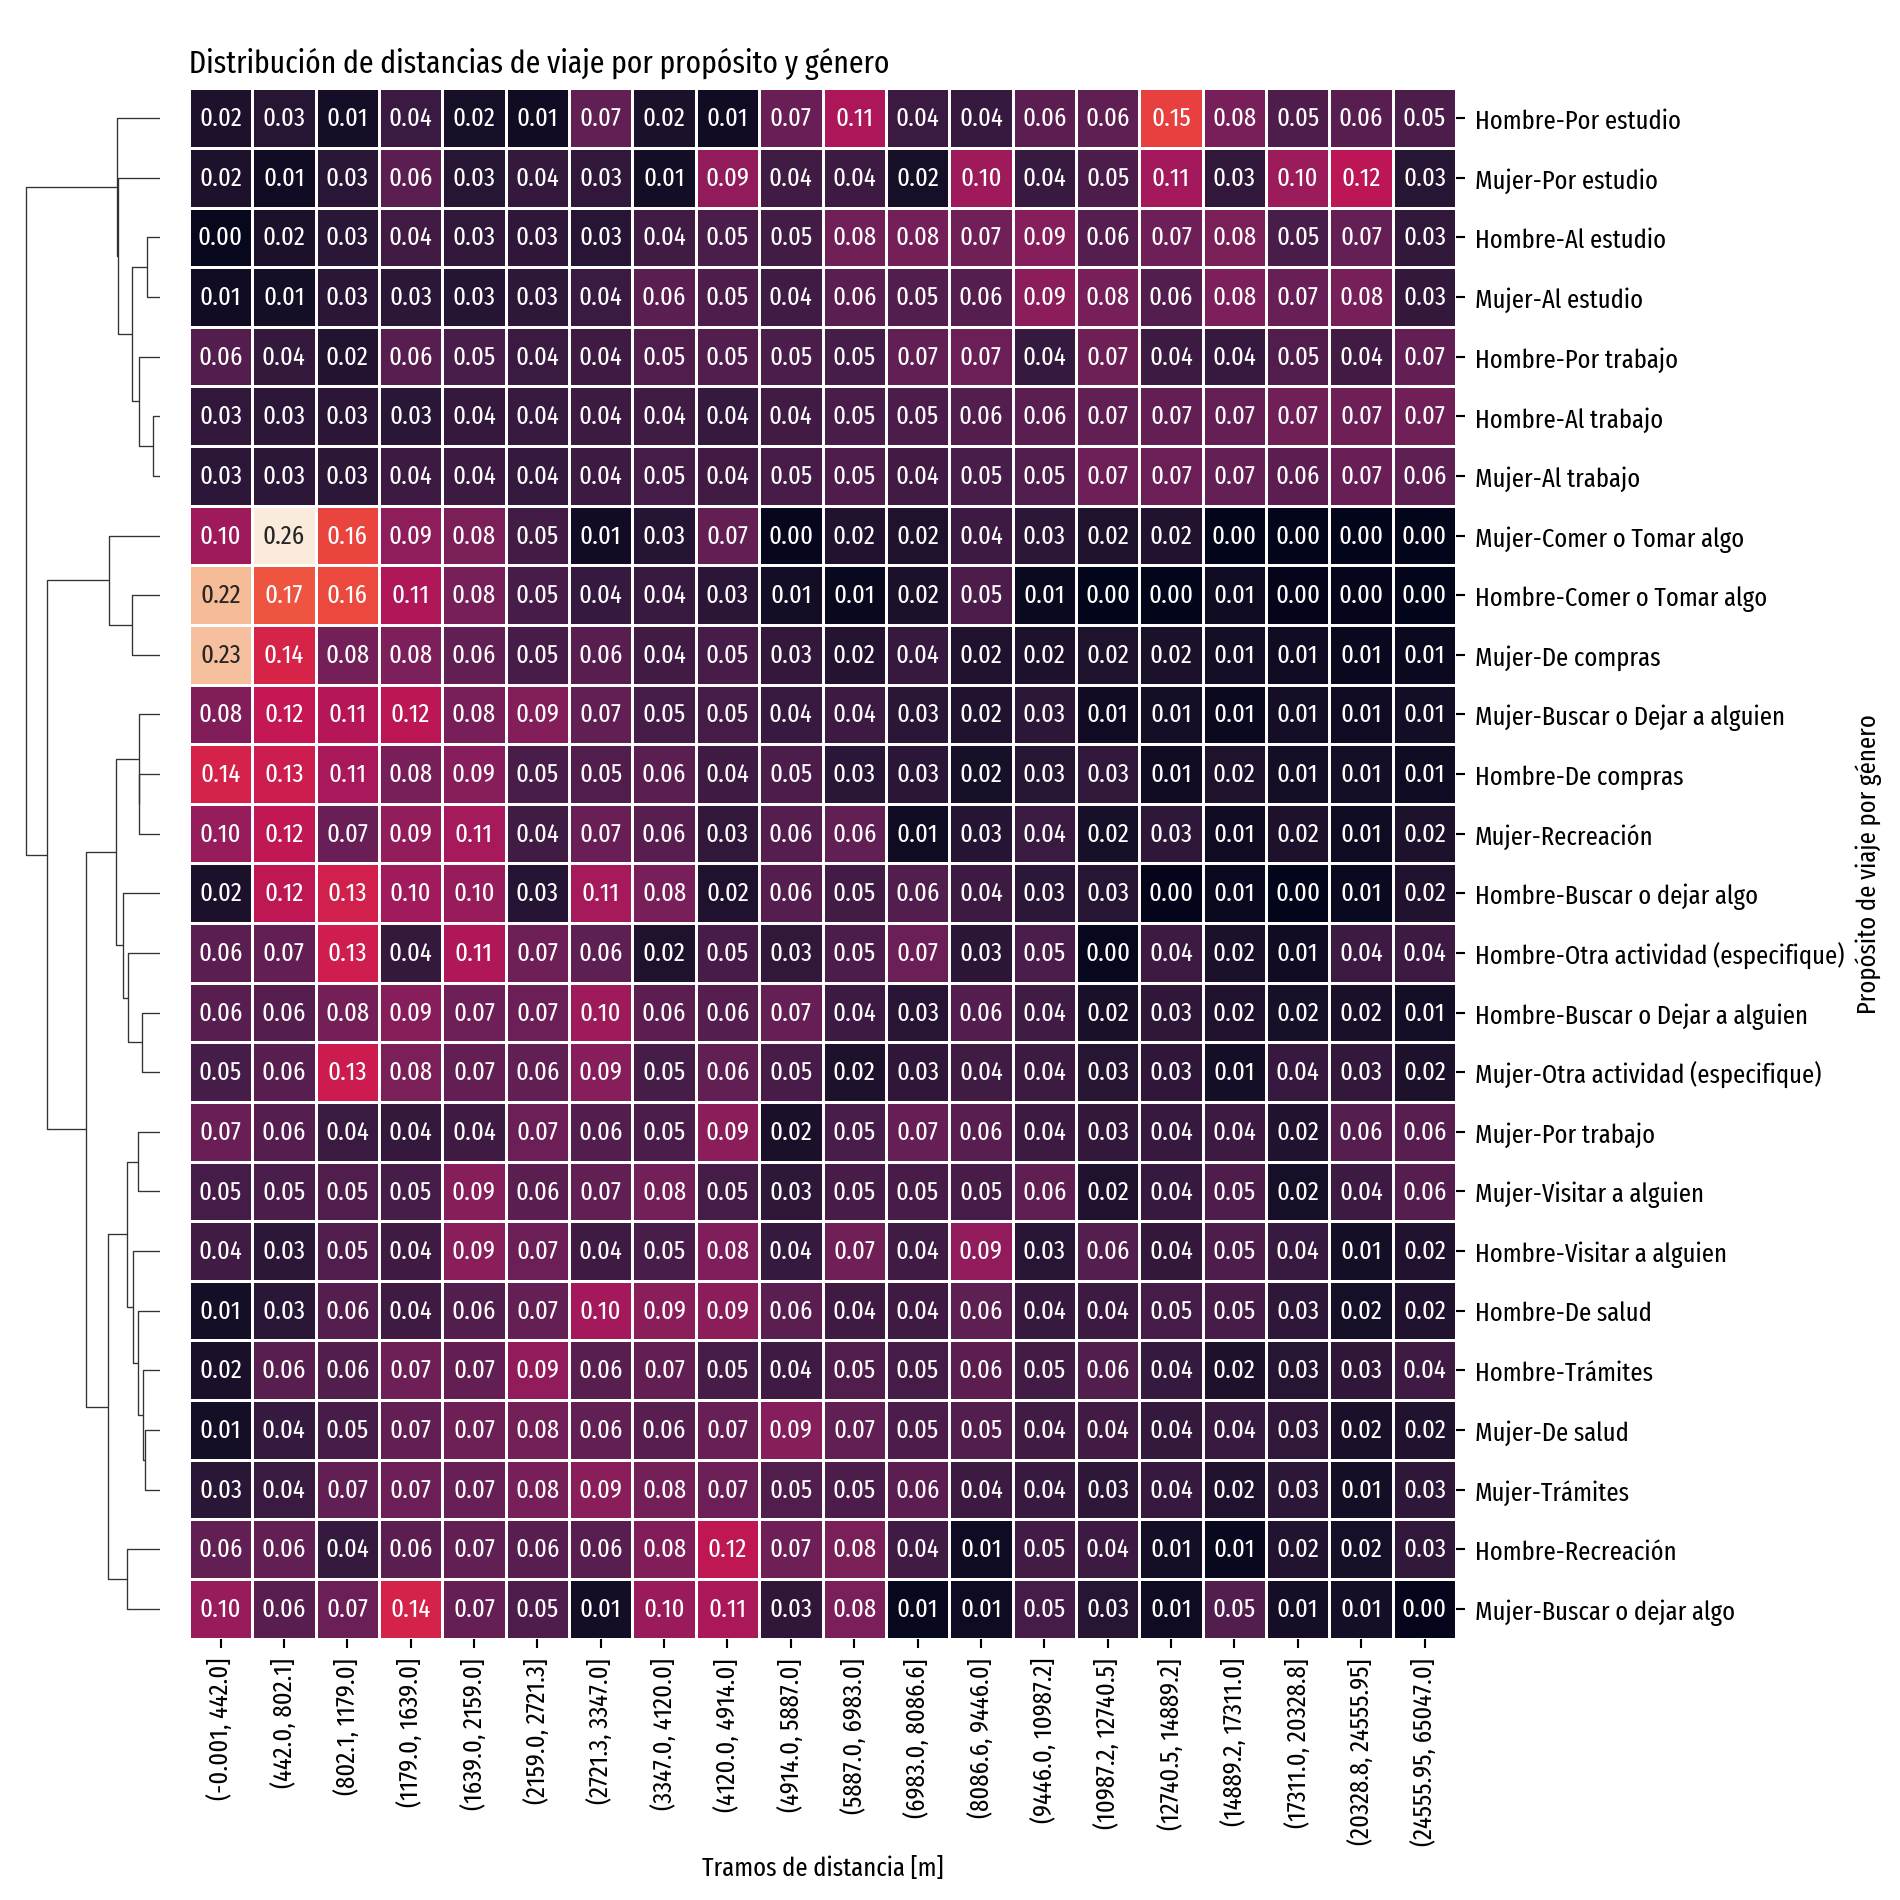

In [54]:
g = sns.clustermap(
    analysis_trips.groupby(["Sexo", "Proposito", "dist_bin"])["PesoLaboral"]
    .sum()
    .unstack()
    .pipe(normalize_rows),
    col_cluster=False,
    method="ward",
    annot=True,
    fmt=".2f",
    linewidth=0.5,
    cbar_pos=None,
    dendrogram_ratio=(0.1, 0),
)
g.ax_heatmap.set_xlabel("Tramos de distancia [m]")
g.ax_heatmap.set_ylabel("Propósito de viaje por género")
g.ax_heatmap.set_title(
    "Distribución de distancias de viaje por propósito y género", loc="left"
)
g.figure.tight_layout()

In [23]:
zones_with_values = zones[zones['ID'].isin(zone_associations.index)]
len(zones_with_values)

768

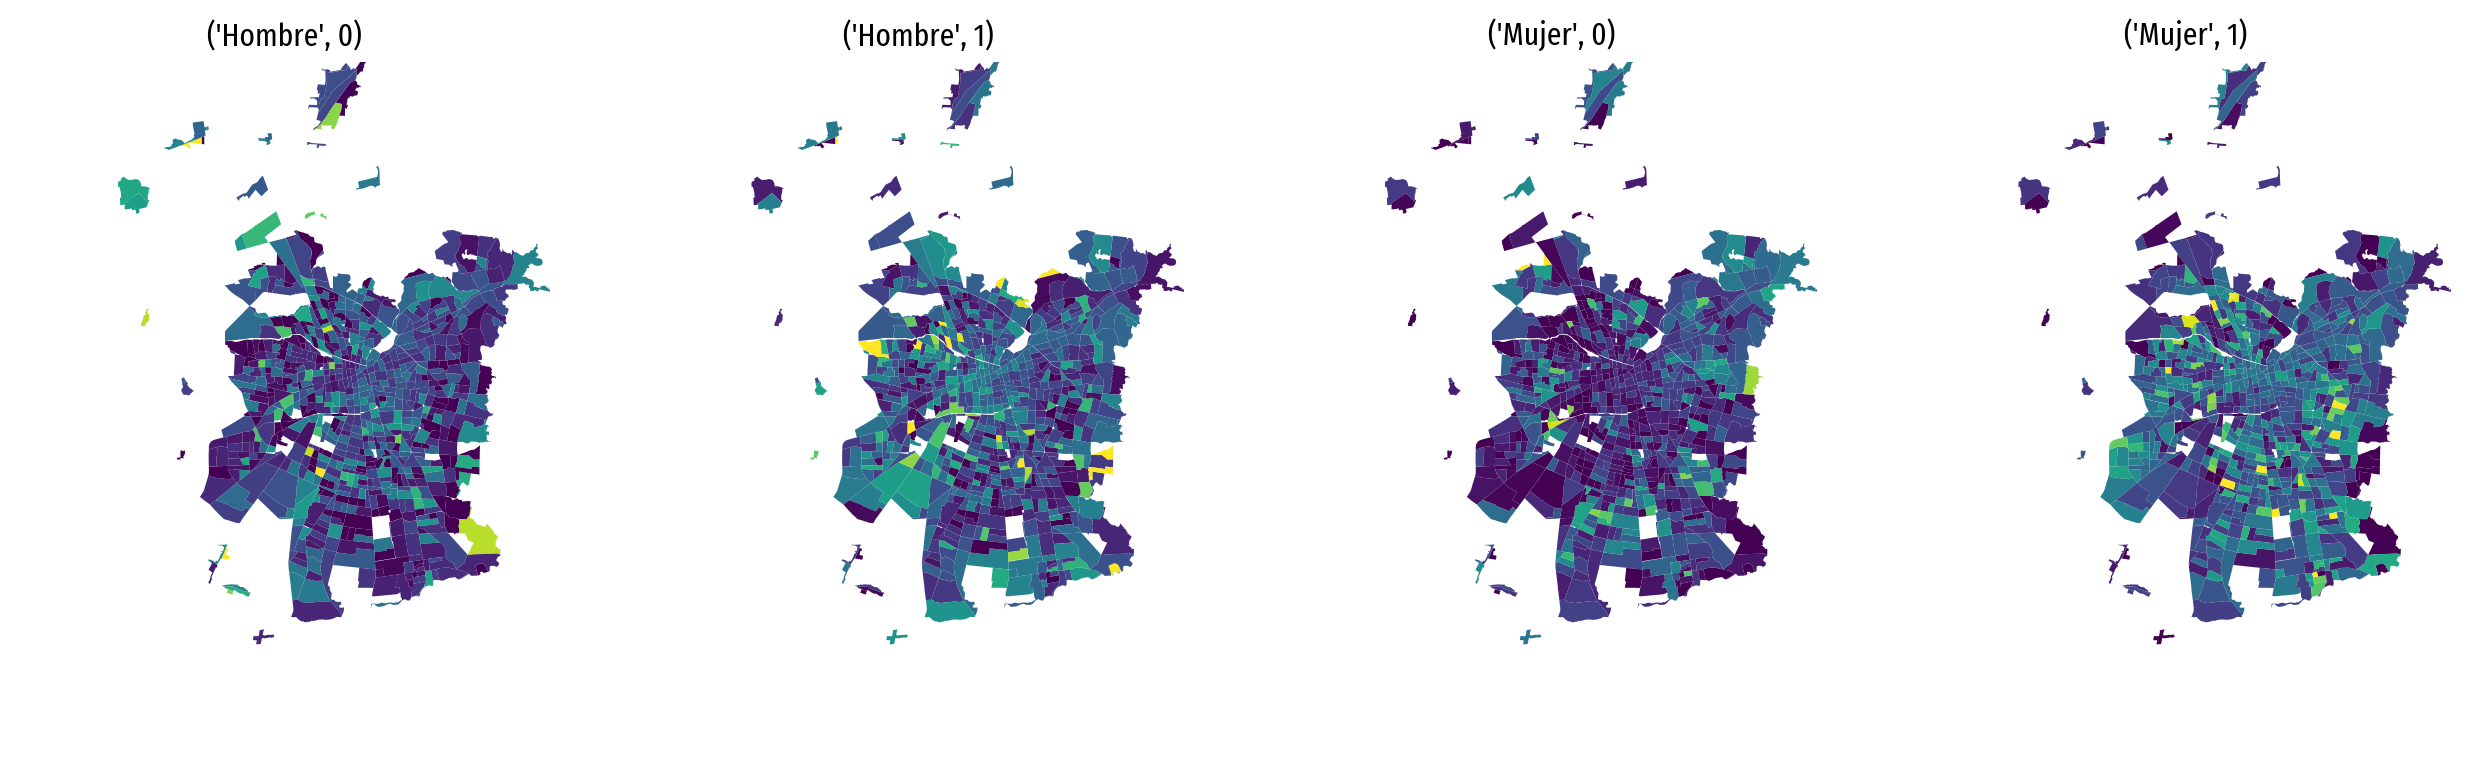

In [24]:
from aves.visualization.figures import small_multiples_from_geodataframe
from itertools import product

fig, axes = small_multiples_from_geodataframe(
    zones, 4, height=4
)

for ax, cols in zip(axes.flatten(), product(('Hombre', 'Mujer'), (0, 1))):
    ax.set_title(cols)
    zones_with_values.join(zone_associations[cols[0]][cols[1]].rename('weight'), on='ID').plot(column='weight', ax=ax)

fig.tight_layout()


In [25]:
from libpysal.weights import Rook, Queen, Kernel, spatial_lag

# w = Queen.from_dataframe(zones_with_values)
w = Kernel.from_dataframe(
    zones_with_values.to_crs("epsg:5361"),
    k=4,
    function="gaussian",
    fixed=False,
    diagonal=False,
)
w.transform = "R"

w.n

/home/egraells/miniconda3/envs/aves/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/egraells/miniconda3/envs/aves/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/home/egraells/miniconda3/envs/aves/lib/python3.11/site-packages/li

768

In [26]:
from esda.moran import Moran_Local

lisa = {}

for cols in product(("Hombre", "Mujer"), (0, 1)):
    df = zones_with_values.join(
        zone_associations[cols[0]][cols[1]].rename("weight"), on="ID"
    )
    lisa_cols = Moran_Local(
        df["weight"],
        w,
    )

    lisa[cols] = pd.Series(
        lisa_cols.q * (lisa_cols.p_sim < 0.05).astype(int), index=df.index, name="moran"
    ).map(
        {
            0: "Non-Significant",
            1: "HH (Hot Spots)",
            2: "LH",
            3: "LL (Cold Spots)",
            4: "HL",
        }
    )

In [27]:
cats = sorted(lisa[cols].unique())
cats

['HH (Hot Spots)', 'HL', 'LH', 'LL (Cold Spots)', 'Non-Significant']

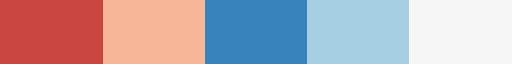

In [28]:
from matplotlib.colors import ListedColormap

colors = sns.color_palette('RdBu', n_colors=5, as_cmap=False)
colors = [colors[0], colors[1], colors[4], colors[3], colors[2]]
cmap = ListedColormap(colors, name='lisa')
cmap

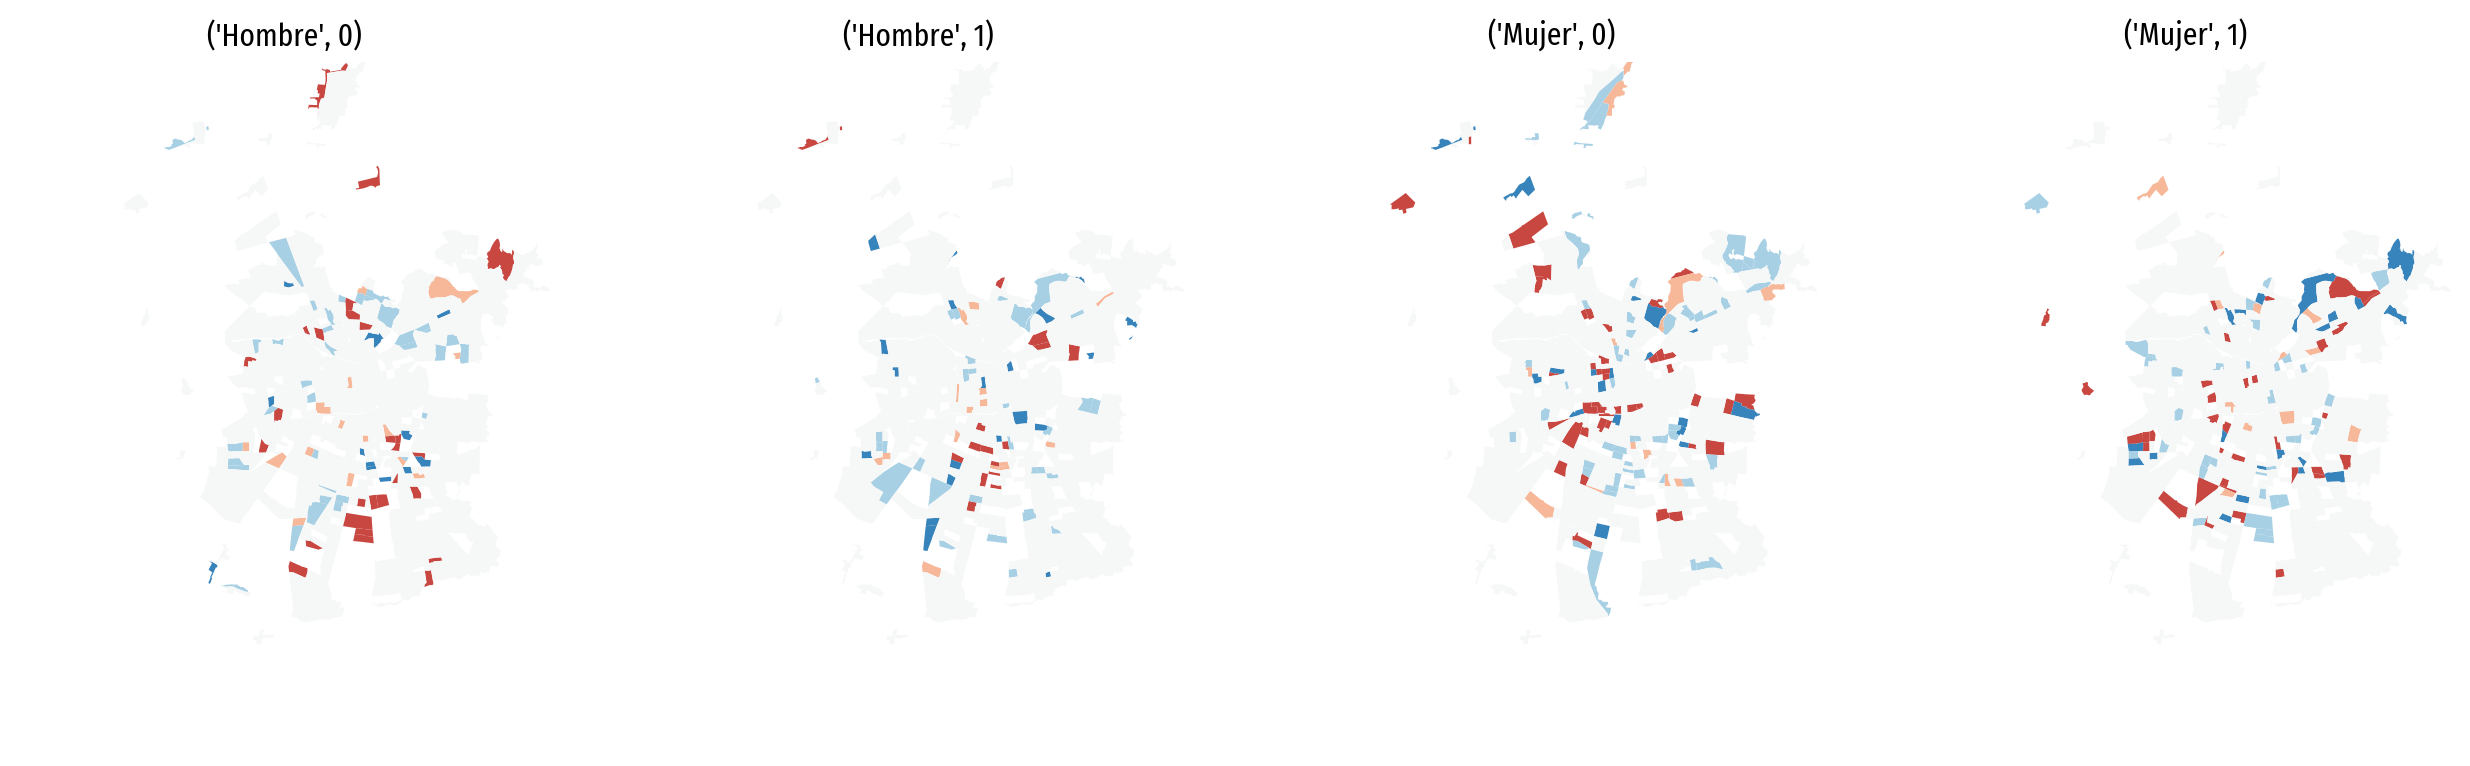

In [29]:
fig, axes = small_multiples_from_geodataframe(
    zones, 4, height=4
)

for ax, cols in zip(axes.flatten(), product(('Hombre', 'Mujer'), (0, 1))):
    ax.set_title(cols)
    zone_cols = zones_with_values.join(lisa[cols], on='ID')

    for color, cat in zip(colors, cats):
        zone_cols[zone_cols['moran'] == cat].plot(ax=ax, color=color)
    #zones_with_values.join(lisa[cols], on='ID').plot(column='moran', ax=ax)

fig.tight_layout()